### Market Behavior Updates

/opt/homebrew/Caskroom/miniconda/base/envs/trading/lib/python3.8/site-packages/arctic/store/_pandas_ndarray_store.py:8: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel

Bad key text.latex.preview in file /opt/homebrew/Caskroom/miniconda/base/envs/trading/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/homebrew/Caskroom/miniconda/base/envs/trading/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
htt

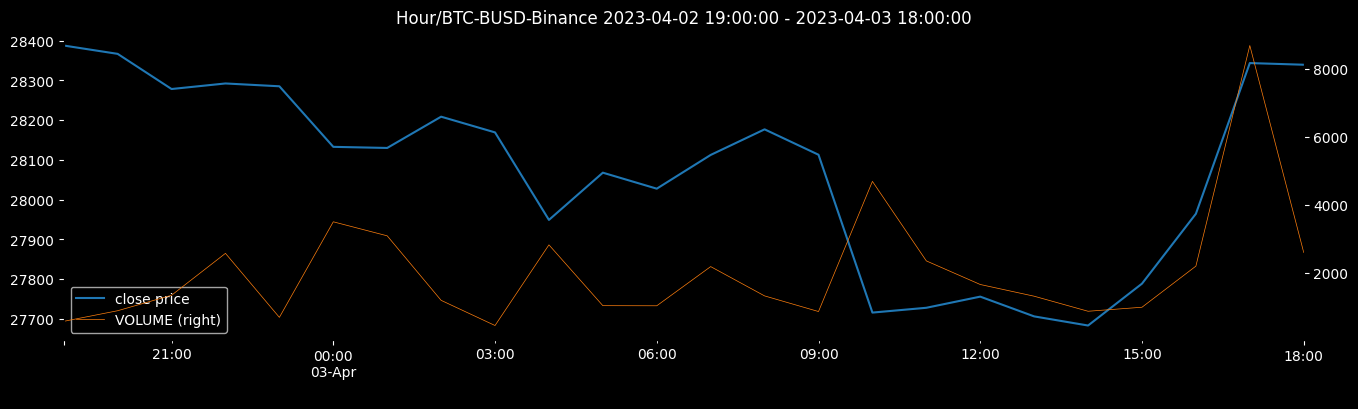

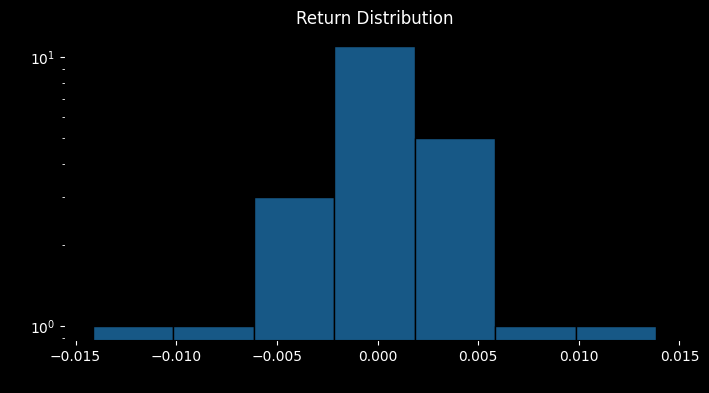

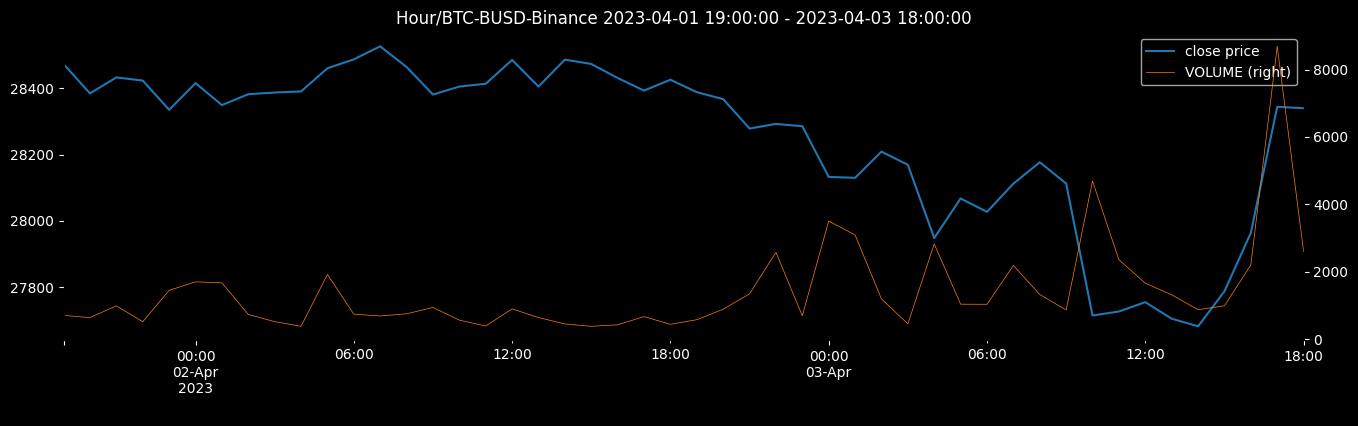

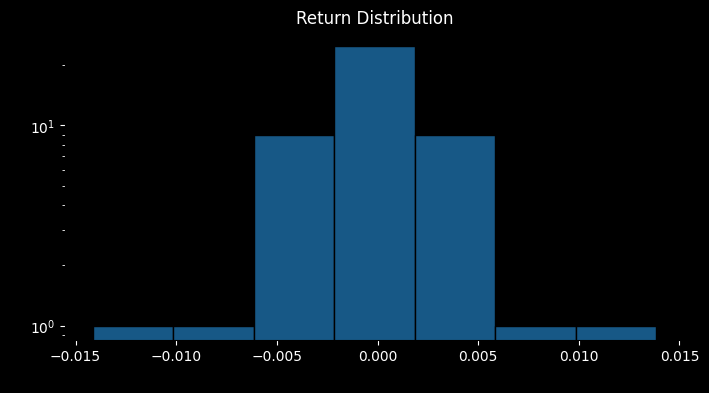

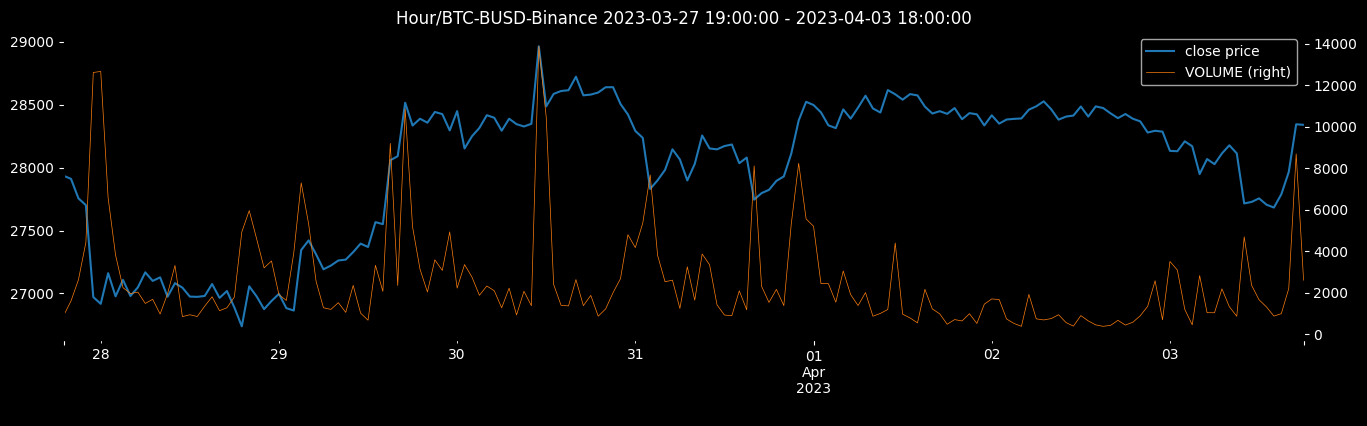

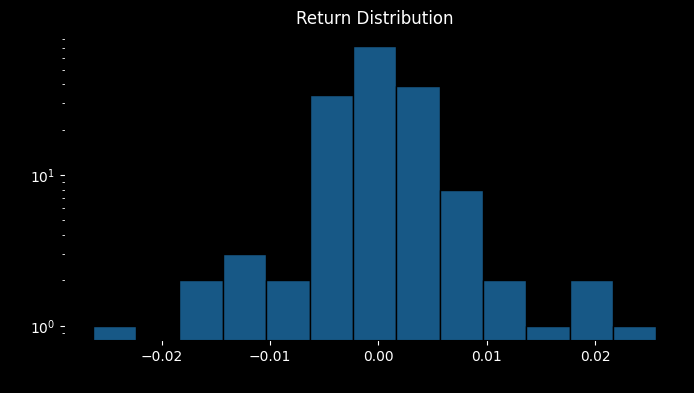

In [1]:
from paper.monitor import screen
from paper.sysproduction.update_historical_prices import update_historical_prices
from sysquant.estimators.vol import simple_ewvol_calc
from scipy.stats import gmean
from paper.topic.common_import import *

update_historical_prices()

screen(look_back_days=1, vol_look_back_days=0)
screen(look_back_days=2, vol_look_back_days=0)
screen(look_back_days=7, vol_look_back_days=0)

### Rule Behavior Updates

None


/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:35: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


2023-03-28 20:02:57 {'type': 'Update-Historical-Prices', 'instrument_code': 'BNB-BUSD-Binance', 'component': 'arcticPerpetualsPricesData'}  Wrote 295 lines of prices for BNB-BUSD-Binance at Frequency.Hour to Arctic connection: host localhost, db production, collection perpetual_prices_v3
2023-03-28 20:02:57 {'type': 'Update-Historical-Prices', 'instrument_code': 'BNB-BUSD-Binance', 'component': 'arcticPerpetualsPricesData'}  Added 1 additional rows of data
2023-03-28 20:02:57 {'type': 'Update-Historical-Prices', 'instrument_code': 'BNB-BUSD-Binance'}  Added 1 rows at frequency Frequency.Hour for BNB-BUSD-Binance
None
2023-03-28 20:02:58 {'type': 'Update-Historical-Prices', 'instrument_code': 'BNB-BUSD-Binance', 'component': 'arcticPerpetualsPricesData'}  Wrote 19325 lines of prices for BTC-BUSD-Binance at Frequency.Hour to Arctic connection: host localhost, db production, collection perpetual_prices_v3
2023-03-28 20:02:58 {'type': 'Update-Historical-Prices', 'instrument_code': 'BNB-BUS

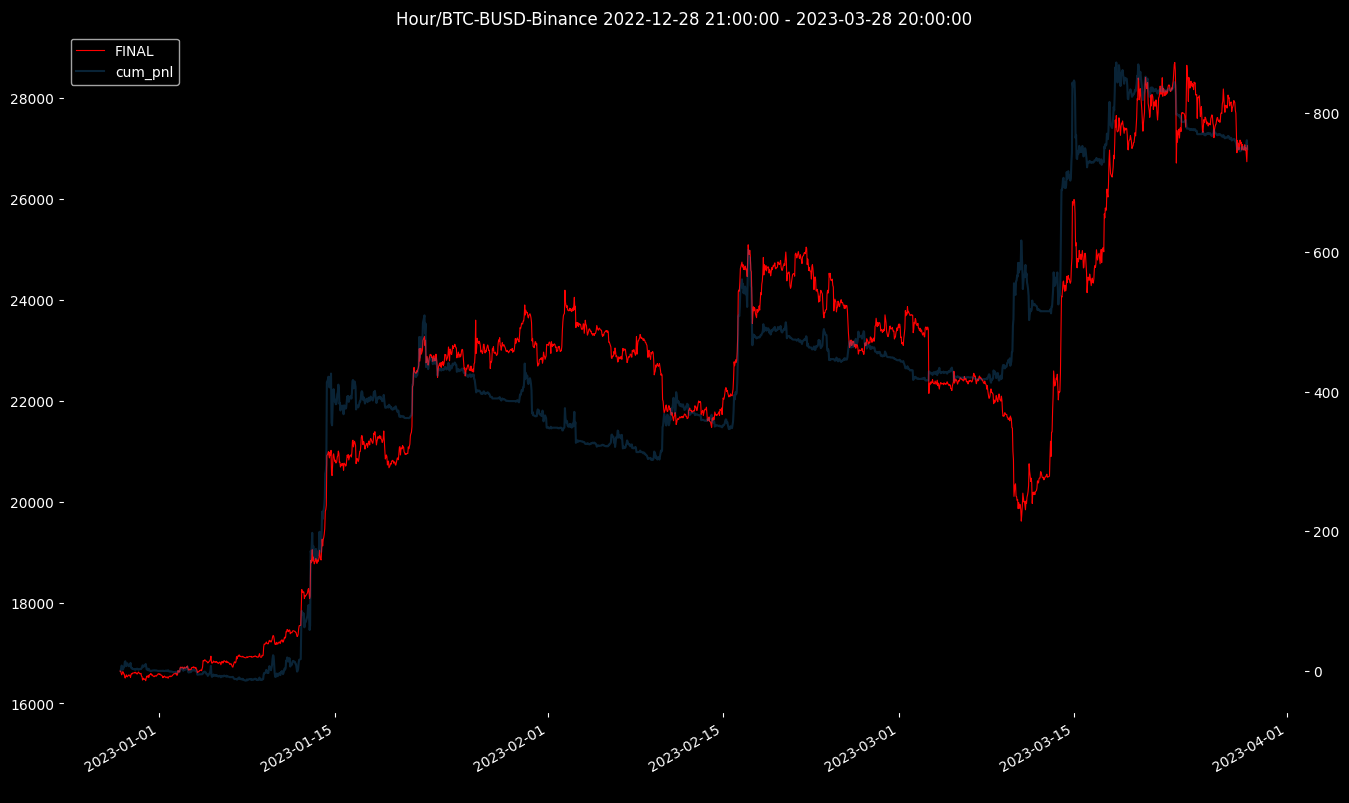

In [14]:
from sysquant.estimators.vol import robust_vol_calc
from paper.topic.common_import import *
from paper.sysproduction.update_historical_prices import update_historical_prices

update_historical_prices()

data = system.data
instrument_code = 'BTC-BUSD-Binance'
Fre = 'Hour'
price = data.hourly_prices(instrument_code)
capital = 1000
value_per_point = 1
risk_target = 0.5
RecentDys = 90
target_abs_forecast = 1.74
L_Fast = 12

def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback

    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # https://qoppac.blogspot.com/2015/05/systems-building-futures-rolling.html

    # price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 4 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma
    vol = robust_vol_calc(price.diff())
    return raw_ewmac / vol

ewmac = calc_ewmac_forecast(price, L_Fast)
ewmac.columns = ['forecast']

from systems.accounts.account_forecast import pandl_for_instrument_forecast
vol, position, account = pandl_for_instrument_forecast(
    forecast=ewmac,
    price = price,
    capital = capital,
    value_per_point=value_per_point,
    risk_target = risk_target,
    target_abs_forecast = target_abs_forecast,
    SR_cost=0.1,
    delayfill=True
    )
position = position.round(2).rename('position')
# mean reverting
# position = position * -1

end = pd.Timestamp.now()
start = end - np.timedelta64(RecentDys, "D")
period = (start, end)
price = select_period(price, period)
print('market price from {} to {}, diff is {}\n'.format(price.iloc[0], price.iloc[-1], price.iloc[-1] - price.iloc[0]))
position = select_period(position, period)

ax1 = price.plot(figsize=(16, 10), title='{}/{} {} - {}'.format(Fre, instrument_code, price.index[0], price.index[-1]), color='r', lw=0.8)
# ax2 = price.pct_change().rename('pct chg').plot(secondary_y=True)
# _ = ax2.hlines(0, price.index[0], price.index[-1], colors='gray', linestyles='dashed')

pnl = (position.shift(1) * price.diff()).rename('pnl')
cum_pnl = pnl.cumsum().rename('cum_pnl')
ax2 = cum_pnl.plot(secondary_y=True, alpha=0.3)
drawdown = strategy_functions.drawdown(cum_pnl).rename('drawdown')
# ax2 = drawdown.plot(secondary_y=True, alpha=0.3)
print('trading capital is {},  cum pnl is {}, max drawdown is {}\n'.format(capital, cum_pnl.iloc[-1], drawdown.min(skipna=True)))

lines = ax1.get_lines() + ax2.get_lines()
ax2.legend(lines, [line.get_label() for line in lines], loc='upper left')
plt.show()

show(position)

/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:35: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


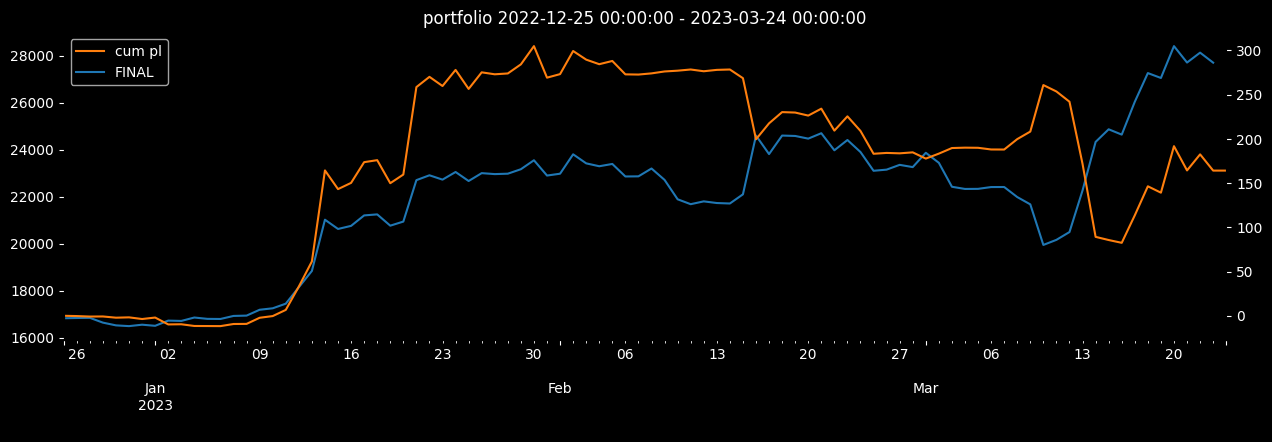

In [13]:
from paper.topic.common_import import *

Recent_days  = 90

# for ins in system.portfolio.get_instrument_list():
#     pos = system.portfolio.get_actual_position(ins).rename(ins)
#     show(pos)

# show(system.positionSize.get_subsystem_position('BTC-BUSD-Binance'))

pl = system.accounts.portfolio(roundpositions=False)

# print(pl.sharpe())
# print(pl.calmar())
# print(pl.ann_mean())
# print(pl.avg_drawdown())
# print(pl.worst_drawdown())
# print(pl.time_in_drawdown())

# pct_pl = (pl / system.accounts.get_notional_capital()).rename('pct pl')
# pct_pl.plot(secondary_y=True, figsize=(15,4))

btc = system.data.daily_prices('BTC-BUSD-Binance').tail(Recent_days)
ax2 = btc.plot(figsize=(15,4), title='BTC-BUSD-Binance {} - {}'.format(btc.index[0], btc.index[-1]))

cum_pl = pl.tail(Recent_days).cumsum().rename('cum pl')
ax1 = cum_pl.plot(figsize=(15,4), title='portfolio {} - {}'.format(cum_pl.index[0], cum_pl.index[-1]), secondary_y=True)


lines = ax1.get_lines() + ax2.get_lines()
ax2.legend(lines, [line.get_label() for line in lines], loc='upper left')
# print(system.accounts.portfolio().stats())
# show(system.portfolio.get_instrument_weights())
# print((1500+2500)/1500)

### Account Balance

In [27]:
client = get_client()
position = pd.DataFrame(client.futures_position_information(symbol='BTCBUSD')).T
show(position)

_account = client.futures_account()
assets = _account['assets']
usdt = next(filter(lambda item:item['asset'] == 'BUSD', assets))
usdt = pd.DataFrame([usdt])[['maintMargin', 'marginBalance', 'unrealizedProfit', 'walletBalance', 'crossWalletBalance']].T
show(usdt)

### Market Reflections

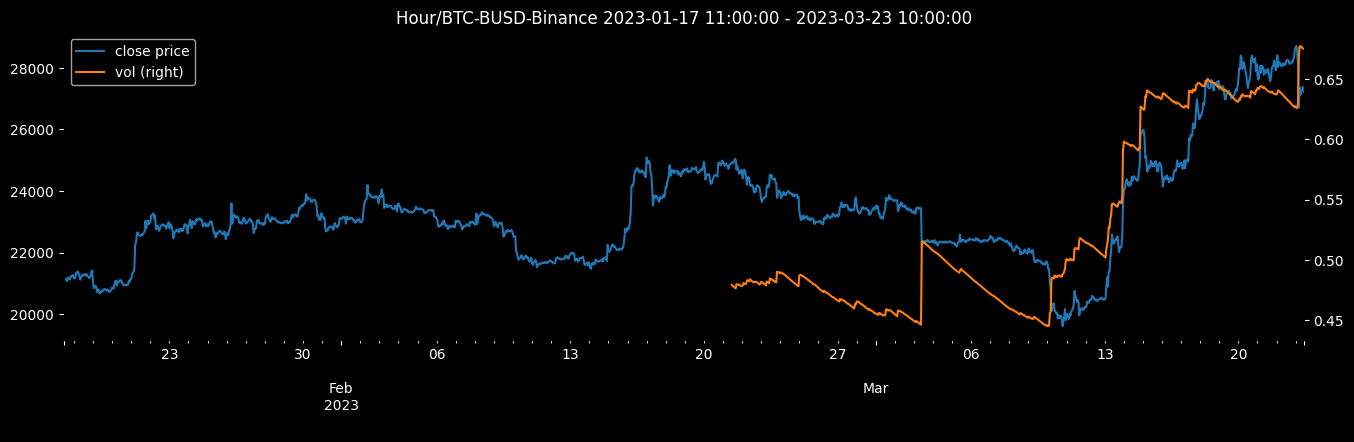

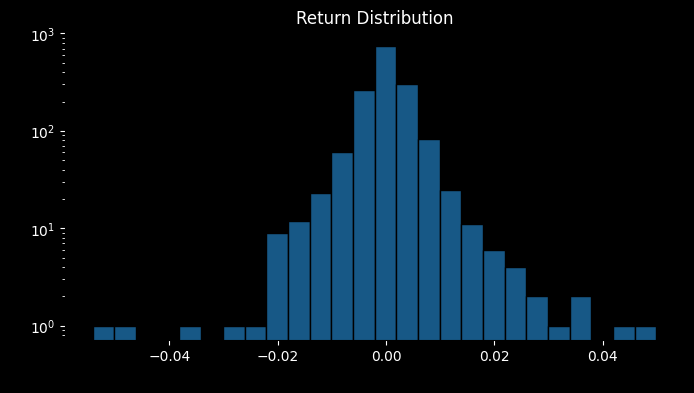

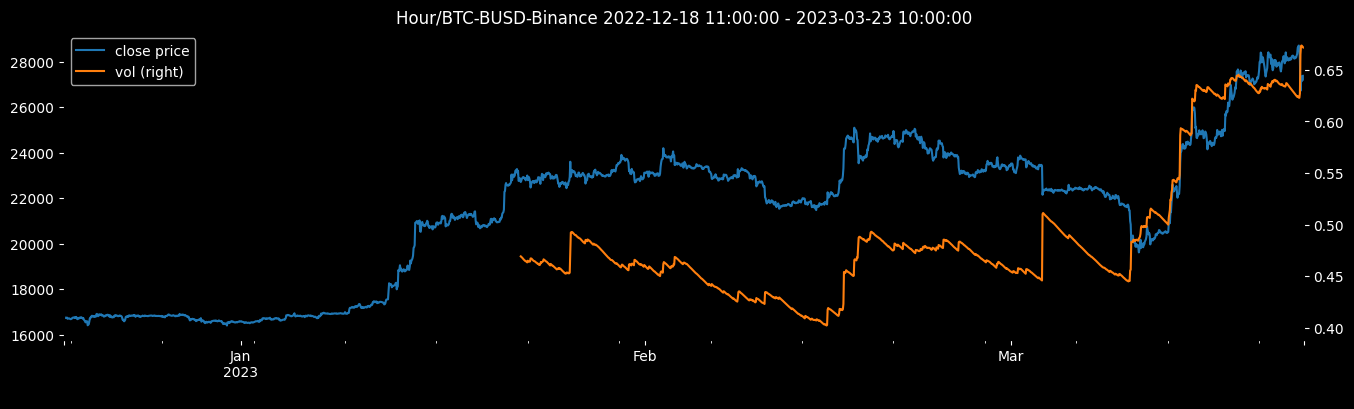

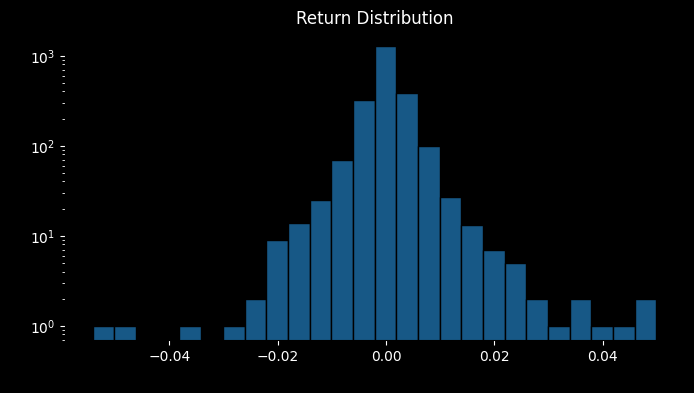

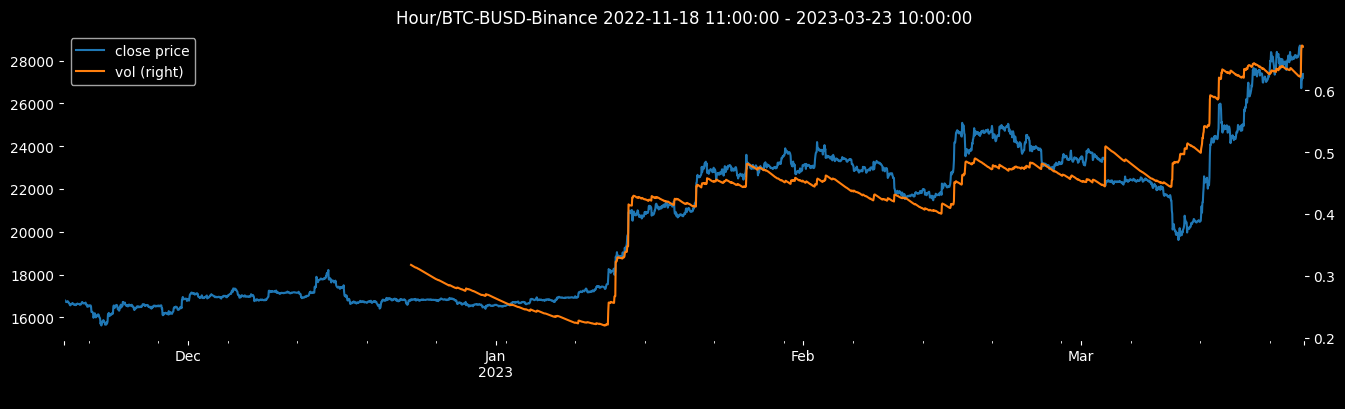

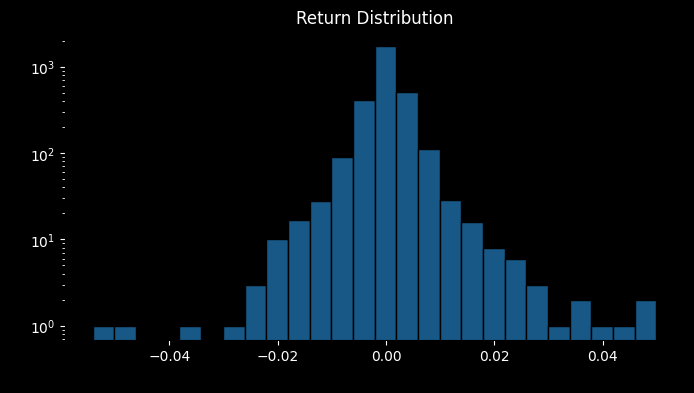

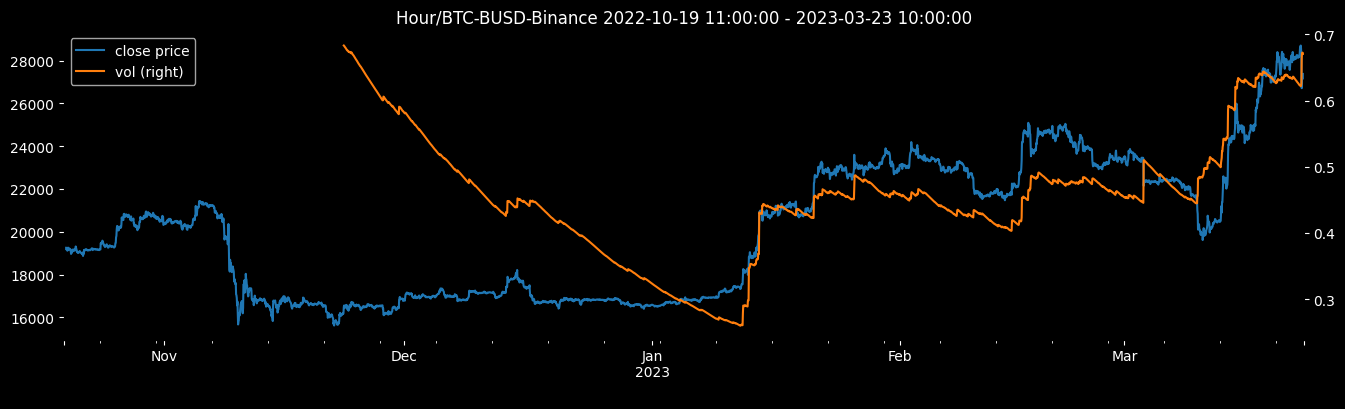

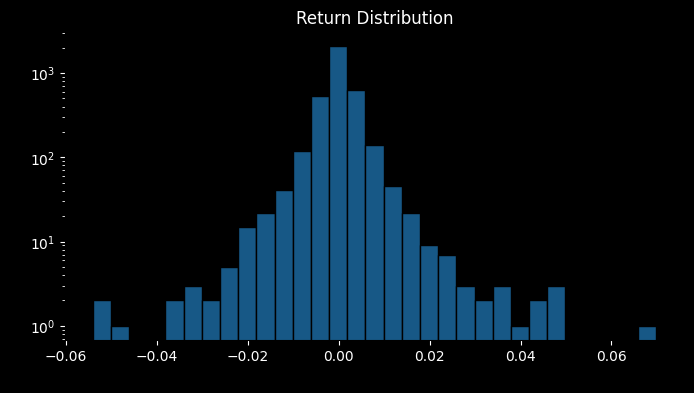

In [6]:
vol_look_back_days = 35
screen(look_back_days=30 * 1, vol_look_back_days=vol_look_back_days)
screen(look_back_days=30 * 2, vol_look_back_days=vol_look_back_days)
screen(look_back_days=30 * 3, vol_look_back_days=vol_look_back_days)
screen(look_back_days=30 * 4, vol_look_back_days=vol_look_back_days)

mean=17285.2617626648, gmean=17240.151046080016, pct_chg=-0.18855180980980013


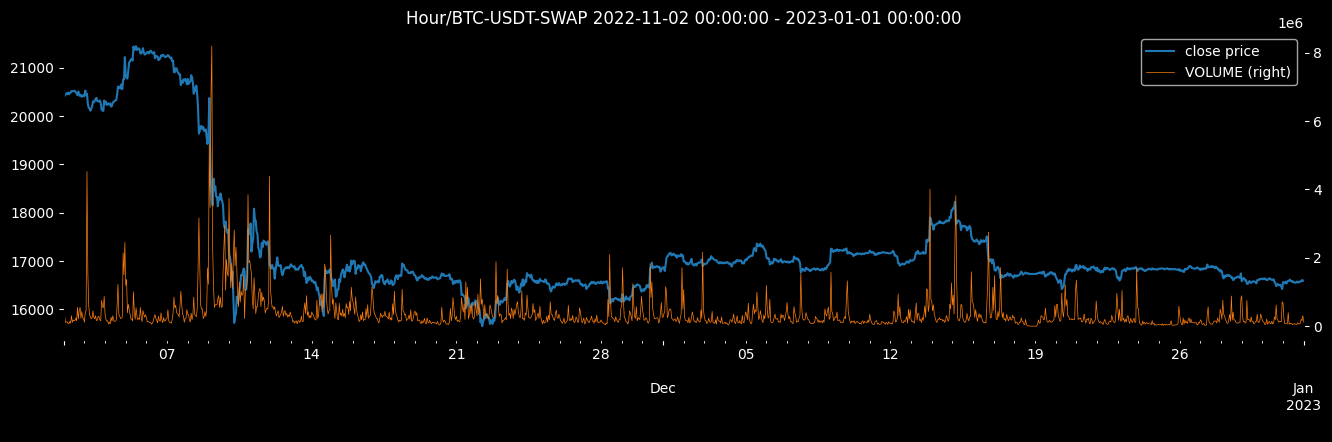

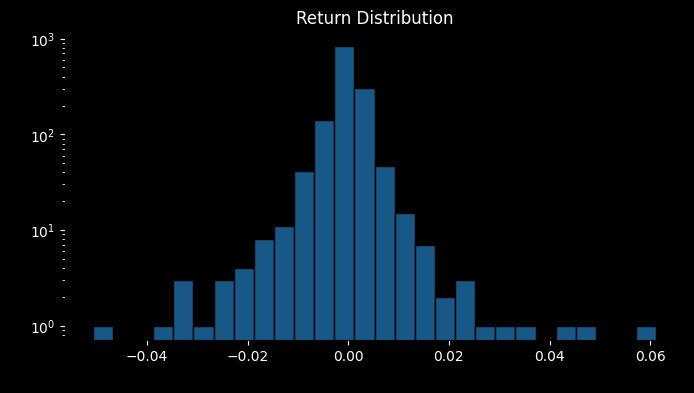

In [ ]:
# screen(look_back_days=1, vol_look_back_days=0, end=pd.Timestamp('2022-11-10'))
# screen(look_back_days=2, vol_look_back_days=0, end=pd.Timestamp('2022-11-10'))
# screen(look_back_days=3, vol_look_back_days=0, end=pd.Timestamp('2022-11-10'))

screen(look_back_days=30 * 2, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')
# screen(look_back_days=30 * 6, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')
# screen(look_back_days=30 * 12, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')
# screen(look_back_days=30 * 30, vol_look_back_days=0, end=pd.Timestamp('2023-01-01'), ins='BTC-USDT-SWAP')

### Mis

In [ ]:
st = '2020-11-01'
et = '2021-01-01'

pl = system.accounts.portfolio().to_frame()
pl = select(pl, st, et)
pct_pl = (pl / system.accounts.get_notional_capital())
pct_pl.plot(secondary_y=True, figsize=(15,5))
cum_pl = pl.cumsum(axis=0)
cum_pl.plot(figsize=(15,5))
plt.show()

btc = system.data.daily_prices('BTC-USDT-SWAP')
btc = select(btc, st, et)
btc.plot(figsize=(15,5))
btc.pct_change().plot(secondary_y=True)

NameError: name 'select' is not defined

In [ ]:
import pandas as pd
st = '2020-11-16'
et = '2020-12-01'

position_list = []
for ins in system.portfolio.get_instrument_list():
    if 'DOGE' in ins:
        continue
    position = system.portfolio.get_actual_position(ins).rename(ins)
    position = select(position, st, et)
    position_list.append(position)
pd.concat(position_list, axis=1).plot(secondary_y=True, figsize=(15,4), legend=True)
plt.show()

btc = system.data.daily_prices('BTC-USDT-SWAP')
btc = select(btc, st, et)
btc.plot(figsize=(15,4))
btc.pct_change().rename('pct change').plot(secondary_y=True, legend=True)

print(19_000 * 5 * 0.01  / system.accounts.get_notional_capital() )

In [ ]:
import pandas as pd
from syscore.dateutils import ROOT_BDAYS_INYEAR


st = '2020-11-16'
et = '2020-12-01'

tmp_list = []
for ins in system.portfolio.get_instrument_list():
    tmp = system.positionSize.get_price_volatility (ins).rename(ins)
    tmp = select(tmp, st, et)
    tmp_list.append(tmp)
pd.concat(tmp_list, axis=1).plot(secondary_y=True, figsize=(15,4), legend=True)
plt.show()

btc = system.data.daily_prices('BTC-USDT-SWAP')
btc = select(btc, st, et)
btc.plot(figsize=(15,4))
btc.pct_change().plot(secondary_y=True)

print(ROOT_BDAYS_INYEAR * 3)

In [ ]:
import ccxt
from paper.sysinit.scrape_okx_history_prices import fetch_once

st = '2020-11-21T00:00+00' 
et = '2020-12-01' 
exchange = ccxt.binance()
exchange = ccxt.binanceusdm()
exchange = ccxt.okex5()
symbol = 'BTC/USDT'
symbol = 'BTC-USDT-SWAP'
df = fetch_once(st, symbol, '1d', exhcnage=exchange)
prices = df[df.index<=et]
prices = prices.loc[:, 4]
prices.plot(figsize=(15,5))
prices.pct_change().rename('pct change').plot(figsize=(15,5), secondary_y=True, legend=True)

In [ ]:
import ccxt
from paper.sysinit.scrape_okx_history_prices import fetch_once

st = '2020-11-25T10:00+08' 
et = '2020-11-27' 
exchange = ccxt.binance()
exchange = ccxt.binanceusdm()
exchange = ccxt.okex5()
symbol = 'BTC/USDT'
symbol = 'BTC-USDT-SWAP'
df = fetch_once(st, symbol, '1h', exhcnage=exchange)
prices = df[df.index<=et]
prices = prices.loc[:, 4]
prices.plot(figsize=(15,5))
prices.pct_change().plot(figsize=(15,5), secondary_y=True)

In [ ]:
show(system.positionSize.get_subsystem_position('BTC-USDT-SWAP').tail(30))
system.accounts.pandl_for_subsystem('BTC-USDT-SWAP').tail(30).cumsum().plot()
print(250 / 1500)
print(30 / (361 ** 0.5))

In [ ]:
system.accounts.pandl_for_subsystem('BTC-USDT-SWAP').stats()
system.accounts.pandl_for_subsystem('BTC-USDT-SWAP').cumsum().plot()

In [ ]:
s1 = system.rawdata.normalised_price_for_asset_class("BTC-USDT-SWAP").rename('asset class')
s2 = system.rawdata.get_cumulative_daily_vol_normalised_returns("BTC-USDT-SWAP").rename('BTC')
s3 = system.rawdata.get_cumulative_daily_vol_normalised_returns("ETH-USDT-SWAP").rename('ETH')
s4 = system.rawdata.get_cumulative_daily_vol_normalised_returns("BNB-USDT").rename('BNB')
# ss = [s1, s2, s3, s4]
ss = [select(s, '2023-01-01', '2023-12-31') for s in [s1, s2, s3, s4]]
ss = [s - s.iloc[0] for s in ss]

pd.concat(ss, axis=1).plot(legend=True, figsize=(15,8))
s2
# system.rawdata.get_cumulative_daily_vol_normalised_returns("ADA-USDT-SWAP").rename('ADA').plot(legend=True)
# system.rawdata.get_cumulative_daily_vol_normalised_returns("XRP-USDT-SWAP").rename('XRP').plot(legend=True)

In [ ]:
ins_list = ['BTC-USDT-SWAP', 'ETH-USDT-SWAP', 'BNB-USDT']

'''portfolio'''
# print(system.accounts.portfolio().stats())
# system.accounts.portfolio().cumsum().rename('port').plot(legend=True, figsize=(15,8))
# plt.show()


for ins in ins_list:
    curve = system.accounts.pandl_for_subsystem(ins)
    curve.cumsum().rename(ins).plot(legend=True, figsize=(15,8))
    print('{} sharpe={} calmar={}'.format(ins, curve.sharpe(), curve.calmar()))
    plt.show()

    for rule in ['ewmac4', 'relmomentum10']:
        curve = system.accounts.pandl_for_instrument_forecast(ins, rule)
        curve.cumsum().rename('{}-{}'.format(ins, rule)).plot(legend=True, figsize=(15,8))
        print('{}={} sharpe={} calmar={}'.format(ins, rule, curve.sharpe(), curve.calmar()))
    plt.show()


In [ ]:
days = 14
daily = system.rawdata.get_daily_prices('BTC-USDT-SWAP').rename('daily').tail(days)
hourly = system.rawdata.get_hourly_prices('BTC-USDT-SWAP').rename('hourly').tail(24 * days)

hourly.plot(figsize=(15,6), legend=True)
daily.index = [date + pd.Timedelta('17h') for date in daily.index]
daily.plot(figsize=(15,6), legend=True, style='o')

In [ ]:
show(daily)
show(hourly)